In [2]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
if gpus:
    try:
        # Imprime detalles de la(s) GPU(s) detectada(s)
        for gpu in gpus:
            print(f"Name: {gpu.name}, Type: {gpu.device_type}")
            tf.config.experimental.set_memory_growth(gpu, True) # Opcional: evita que TF reserve toda la memoria GPU al inicio
    except RuntimeError as e:
        print(e) # Imprime cualquier error durante la inicialización

TensorFlow Version: 2.15.0
Num GPUs Available: 0


2025-04-26 22:15:35.655483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-26 22:15:36.310730: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [1]:
# -*- coding: utf-8 -*-
# Importamos las librerías necesarias
import findspark
findspark.init() # Asegurémonos de que encuentre Spark

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, date_trunc
from pyspark.sql.types import StringType, BooleanType, TimestampType, DoubleType, IntegerType, LongType # Tipos necesarios
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler as SparkMinMaxScaler, StringIndexer
from pyspark.ml.functions import vector_to_array # Útil para ver vectores

from sklearn.preprocessing import MinMaxScaler as SklearnMinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

print("Librerías importadas correctamente.")

2025-04-26 22:09:01.657714: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 22:09:02.655721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-26 22:09:02.655822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-26 22:09:02.837920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 22:09:03.192144: I tensorflow/core/platform/cpu_feature_guar

Librerías importadas correctamente.


In [3]:
# --- 1. Configuración de Spark ---
# Configuramos e iniciamos nuestra sesión de Spark en modo local.
# Usamos rutas absolutas para los directorios de warehouse y metastore para evitar problemas.
print("Configurando Spark Session...")
spark = SparkSession.builder \
    .appName("PrediccionTiempoEsperaAvionNotebook") \
    .config("spark.master", "local[*]") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .config("spark.sql.warehouse.dir", f"file:///{os.path.abspath('spark-warehouse')}") \
    .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={os.path.abspath('derby_metastore_db')}") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

sc = spark.sparkContext
print(f"Spark Session creada. Default FS: {spark.conf.get('spark.hadoop.fs.defaultFS')}")
print(f"Usando optimización Arrow: {spark.conf.get('spark.sql.execution.arrow.pyspark.enabled')}")

# Mostramos la interfaz de usuario de Spark si está disponible (útil para monitorear)
print(f"Spark UI disponible en: {sc.uiWebUrl}")

Configurando Spark Session...


25/04/26 22:17:45 WARN Utils: Your hostname, bryanSpace resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/26 22:17:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Session creada. Default FS: file:///
Usando optimización Arrow: true
Spark UI disponible en: http://10.255.255.254:4040


In [5]:
# --- 2. Definición de Rutas y Carga de Datos ---
# Establecemos las rutas a nuestros archivos Parquet de entrenamiento/prueba y al CSV de meteorología.
# ¡Asegúrate de que estas rutas sean correctas en tu sistema!
BASE_DATA_PATH = "../src/dato/" # Ajusta si es necesario
TRAIN_DATA_PATH = os.path.join(BASE_DATA_PATH, "train_spark.parquet") # <- Cambia a tu ruta real
TEST_DATA_PATH = os.path.join(BASE_DATA_PATH, "test_spark.parquet")   # <- Cambia a tu ruta real
METEO_DATA_PATH = os.path.join(BASE_DATA_PATH, "open-meteo-40.53N3.56W602m-2.csv") # <- Cambia a tu ruta real

print(f"Ruta base de datos: {BASE_DATA_PATH}")
print(f"Cargando datos de entrenamiento desde: {TRAIN_DATA_PATH}")
df_train = spark.read.parquet(TRAIN_DATA_PATH)

print(f"Cargando datos de prueba desde: {TEST_DATA_PATH}")
df_test = spark.read.parquet(TEST_DATA_PATH)

print(f"\nSe cargaron {df_train.count()} registros de entrenamiento.")
print(f"Se cargaron {df_test.count()} registros de prueba.")

Ruta base de datos: ../src/dato/
Cargando datos de entrenamiento desde: ../src/dato/train_spark.parquet


Cargando datos de prueba desde: ../src/dato/test_spark.parquet

Se cargaron 123733 registros de entrenamiento.
Se cargaron 27791 registros de prueba.


In [6]:
# --- Inspección Inicial de Datos ---
# Echamos un primer vistazo al esquema y a algunas filas de los datos de entrenamiento.
print("Esquema del DataFrame de entrenamiento:")
df_train.printSchema()

print("\nPrimeras 5 filas del DataFrame de entrenamiento:")
df_train.show(5, truncate=False)

# Hacemos lo mismo para el de prueba para asegurarnos de que son consistentes
print("\nEsquema del DataFrame de prueba:")
df_test.printSchema()
print("\nPrimeras 5 filas del DataFrame de prueba:")
df_test.show(5, truncate=False)

Esquema del DataFrame de entrenamiento:
root
 |-- takeoff_time: double (nullable = true)
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- icao: string (nullable = true)
 |-- callsign: string (nullable = true)
 |-- holding_point: string (nullable = true)
 |-- runway: string (nullable = true)
 |-- operator: string (nullable = true)
 |-- turbulence_category: string (nullable = true)
 |-- last_min_takeoffs: long (nullable = true)
 |-- last_min_landings: long (nullable = true)
 |-- last_event_turb_cat: string (nullable = true)
 |-- time_since_last_event_seconds: long (nullable = true)
 |-- time_before_holding_point: double (nullable = true)
 |-- time_at_holding_point: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- is_holiday: boolean (nullable = true)
 |-- Z1: boolean (nullable = true)
 |-- KA6: boolean (nullable = true)
 |-- KA8: boolean (nullable = true)
 |-- K3: boolean (nullable = true)
 |-- K2: boolean (nullable = true)
 |-

25/04/26 22:19:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------------------+------+--------+-------------+-------+--------+-------------------+-----------------+-----------------+-------------------+-----------------------------+-------------------------+---------------------+----+-------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------------------+------------------------+-----------------+------------------+-------------+-----------------------+----------------------+---------------+-------------------+-------------------+--------------------+---------+---------------------+----------------------+-----------------------+------------------------------+----------------------------------+----------------------------------+-------------------------------+-----------------+
|takeoff_time|timestamp              |icao  |callsign|holding_point|runway |operator|turbulence_category|last_min_takeoffs|last_m

In [8]:
# --- 3. Función para añadir datos meteorológicos ---
# Definimos una función reutilizable para cargar el CSV de meteo, procesarlo
# y unirlo a un DataFrame de Spark basado en la hora truncada del timestamp.
def add_meteo_data(spark_df, meteo_csv_path):
    """Carga datos meteorológicos y los une a un DataFrame Spark."""
    print(f"Cargando datos meteorológicos desde: {meteo_csv_path}")
    # Usamos Pandas para leer el CSV por comodidad con skiprows, luego convertimos a Spark DF
    pdf_meteo = pd.read_csv(meteo_csv_path, skiprows=2)
    df_meteo = spark.createDataFrame(pdf_meteo)

    # Renombramos columnas meteo para evitar conflictos y mejorar claridad
    # Les añadimos el prefijo 'meteo_'
    meteo_cols = df_meteo.columns
    prefix = "meteo_"
    for c in meteo_cols:
        if c != 'time': # La columna 'time' se usará para la unión y se renombrará después
            df_meteo = df_meteo.withColumnRenamed(c, f"{prefix}{c}")

    # Convertimos la columna 'time' (string) a timestamp y la renombramos para la unión
    df_meteo = df_meteo.withColumn("time_hour_meteo", to_timestamp(col("time")))
    df_meteo = df_meteo.drop("time") # Eliminamos la columna original 'time' string

    print("Procesando timestamps en el DataFrame principal para la unión...")
    # Creamos una columna truncando el timestamp principal a la hora en punto
    spark_df = spark_df.withColumn("time_hour", date_trunc("hour", col("timestamp")))

    # Unimos los DataFrames por la hora truncada
    print("Uniendo datos principales con datos meteorológicos (join)...")
    # Usamos un left join por si algún registro principal no tiene correspondencia exacta de hora en meteo
    # Aunque con datos horarios, un inner join debería funcionar bien si los rangos coinciden.
    # Cambiamos a inner join como en el código original, asumiendo cobertura completa.
    joined_df = spark_df.join(df_meteo, spark_df["time_hour"] == df_meteo["time_hour_meteo"], how="inner")

    # Eliminamos las columnas de tiempo intermedias usadas para la unión
    joined_df = joined_df.drop("time_hour", "time_hour_meteo")
    print(f"Unión completada. Nuevas columnas añadidas (prefijo '{prefix}').")
    return joined_df

# Ahora aplicamos la función a nuestros DataFrames de entrenamiento y prueba
print("\nAplicando unión meteorológica a datos de entrenamiento...")
df_train = add_meteo_data(df_train, METEO_DATA_PATH)

print("\nAplicando unión meteorológica a datos de prueba...")
df_test = add_meteo_data(df_test, METEO_DATA_PATH)

# Verificamos el esquema resultante y algunas filas del DF de entrenamiento
print("\nEsquema después de añadir datos meteorológicos (entrenamiento):")
df_train.printSchema()
print("\nPrimeras 5 filas del DF de entrenamiento con datos meteorológicos:")
df_train.show(5, truncate=True)


Aplicando unión meteorológica a datos de entrenamiento...
Cargando datos meteorológicos desde: ../src/dato/open-meteo-40.53N3.56W602m-2.csv


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Procesando timestamps en el DataFrame principal para la unión...
Uniendo datos principales con datos meteorológicos (join)...
Unión completada. Nuevas columnas añadidas (prefijo 'meteo_').

Aplicando unión meteorológica a datos de prueba...
Cargando datos meteorológicos desde: ../src/dato/open-meteo-40.53N3.56W602m-2.csv


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Procesando timestamps en el DataFrame principal para la unión...
Uniendo datos principales con datos meteorológicos (join)...
Unión completada. Nuevas columnas añadidas (prefijo 'meteo_').

Esquema después de añadir datos meteorológicos (entrenamiento):
root
 |-- takeoff_time: double (nullable = true)
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- icao: string (nullable = true)
 |-- callsign: string (nullable = true)
 |-- holding_point: string (nullable = true)
 |-- runway: string (nullable = true)
 |-- operator: string (nullable = true)
 |-- turbulence_category: string (nullable = true)
 |-- last_min_takeoffs: long (nullable = true)
 |-- last_min_landings: long (nullable = true)
 |-- last_event_turb_cat: string (nullable = true)
 |-- time_since_last_event_seconds: long (nullable = true)
 |-- time_before_holding_point: double (nullable = true)
 |-- time_at_holding_point: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- is_h

[Stage 11:>                                                         (0 + 1) / 1]

+------------+--------------------+------+--------+-------------+-------+--------+--------------------+-----------------+-----------------+-------------------+-----------------------------+-------------------------+---------------------+----+-------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------------------+------------------------+-----------------+------------------+-------------+-----------------------+----------------------+---------------+-------------------+-------------------+--------------------+---------+---------------------+----------------------+-----------------------+------------------------------+----------------------------------+----------------------------------+-------------------------------+-----------------+-------------------------+------------------------------+-----------------------+-------------------------------+-------------------

In [22]:
# --- 4. Preparación de Características (Spark ML Pipeline) ---

# Definimos nuestra columna objetivo
TARGET_COL = "takeoff_time"

# Identificamos las columnas que NO usaremos como características (features).
# Incluimos identificadores, timestamps brutos y la propia columna objetivo.
excluded_cols = [TARGET_COL, 'timestamp', 'icao', 'callsign', 'event_timestamp',
                 'first_holding_time', 'first_airborne_time', 'first_on_ground_time']

# El resto de columnas serán nuestras características iniciales.
# Obtenemos la lista de columnas del DataFrame de entrenamiento (ya incluye las de meteo)
all_cols = df_train.columns
feature_cols = [c for c in all_cols if c not in excluded_cols]
print(f"\nColumnas de características identificadas ({len(feature_cols)}): {feature_cols}")

# Separamos las características en categóricas y numéricas/booleanas para el pipeline.
# Lo hacemos basándonos en el esquema del DataFrame de entrenamiento.
categorical_cols = []
numerical_cols = []

print("\nIdentificando tipos de columnas para el pipeline...")
for col_name in feature_cols:
    dtype = df_train.schema[col_name].dataType
    # print(f" - Columna: {col_name}, Tipo: {dtype}") # Descomentar para depuración detallada
    if isinstance(dtype, StringType):
        categorical_cols.append(col_name)
    # Tratamos Booleanos como numéricos (Spark los manejará como 0/1 en VectorAssembler)
    elif isinstance(dtype, (DoubleType, IntegerType, LongType, BooleanType)):
         numerical_cols.append(col_name)
    # Advertimos si encontramos Timestamps como features, ya que podrían necesitar tratamiento especial
    elif isinstance(dtype, TimestampType):
         print(f"    ADVERTENCIA: La columna Timestamp '{col_name}' está en las features. Se tratará como numérica (epoch). Considera extraer features de tiempo (hora, día, etc.) si es relevante.")
         # La convertiremos a número (segundos epoch) antes del ensamblador si es necesario,
         # pero VectorAssembler podría manejarlo implícitamente en versiones recientes.
         # Por seguridad, la añadimos a numéricas.
         numerical_cols.append(col_name)
    else:
         print(f"    ADVERTENCIA: Tipo de dato no manejado directamente: {dtype} para columna '{col_name}'. Se omitirá.")

print(f"\nColumnas Categóricas para indexar: {categorical_cols}")
print(f"Columnas Numéricas/Booleanas/Timestamp para ensamblar directamente: {numerical_cols}")

# --- AÑADIR ESTE BLOQUE DE IMPUTACIÓN ---
print("\nImputando valores nulos/NaN en df_train ANTES del pipeline...")

# Estrategia: Rellenar numéricos con 0 y categóricos con un placeholder string.
# (Podrías usar otras estrategias como media/mediana para numéricos con Spark ML Imputer si lo prefieres)

# Rellenar NaNs en columnas numéricas con 0
# Asegúrate de que 'numerical_cols' contiene los nombres correctos
print(f"Rellenando NaNs con 0 en {len(numerical_cols)} columnas numéricas/booleanas...")
df_train = df_train.na.fill(0, subset=numerical_cols)

# Rellenar NaNs/Nulls en columnas categóricas con un string específico
# Asegúrate de que 'categorical_cols' contiene los nombres correctos
placeholder_string = "__MISSING__" # O cualquier string que no exista en tus datos
print(f"Rellenando Nulls con '{placeholder_string}' en {len(categorical_cols)} columnas categóricas...")
df_train = df_train.na.fill(placeholder_string, subset=categorical_cols)

print("Imputación completada en df_train.")
# --- FIN DEL BLOQUE DE IMPUTACIÓN ---

# --- Ahora continúa con la definición del pipeline como antes ---
# 1. Creamos los StringIndexers...
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep') # 'keep' sigue siendo útil por si algo se escapa o para test
    for col in categorical_cols
]
# ... (resto de la definición del pipeline: assembler, scaler, pipeline = Pipeline(...) ) ...

# --- Definición del Pipeline de Spark ML ---
# 1. Creamos los StringIndexers para convertir las columnas categóricas a índices numéricos.
#    'handleInvalid='keep'' asignará un índice especial a valores nuevos en el test set.
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep')
    for col in categorical_cols
]
print(f"\nDefinidos {len(indexers)} StringIndexers.")

# 2. Creamos el VectorAssembler para combinar todas las características (numéricas + categóricas indexadas) en un solo vector.
assembler_input = [f"{c}_index" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(
    inputCols=assembler_input,
    outputCol="features_raw",
    handleInvalid='keep' # Importante para manejar nulos o problemas residuales
)
print(f"Definido VectorAssembler con {len(assembler_input)} columnas de entrada.")

# 3. Creamos un MinMaxScaler de Spark para escalar el vector de características resultante a un rango [0, 1].
#    Esto ayuda a que el modelo de deep learning converja mejor.
scaler = SparkMinMaxScaler(inputCol="features_raw", outputCol="features")
print("Definido SparkMinMaxScaler para escalar el vector de características.")

# 4. Creamos el Pipeline que ejecutará secuencialmente los indexers, el assembler y el scaler.
pipeline = Pipeline(stages=indexers + [assembler, scaler])
print("Pipeline de preprocesamiento definido.")


Columnas de características identificadas (89): ['holding_point', 'runway', 'operator', 'turbulence_category', 'last_min_takeoffs', 'last_min_landings', 'last_event_turb_cat', 'time_since_last_event_seconds', 'time_before_holding_point', 'time_at_holding_point', 'hour', 'weekday', 'is_holiday', 'Z1', 'KA6', 'KA8', 'K3', 'K2', 'K1', 'Y1', 'Y2', 'Y3', 'Y7', 'Z6', 'Z4', 'Z2', 'Z3', 'LF', 'L1', 'LA', 'LB', 'LC', 'LD', 'LE', '36R_18L', '32R_14L', '36L_18R', '32L_14R', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'precipitation (mm)', 'snowfall (cm)', 'weather_code (wmo code)', 'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)', 'is_day ()', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'wind_direction_100m (°)', 'soil_moisture_0_to_7cm (m³/m³)', 'soil_temperature_100_to_255cm (°C)', 'soil_moisture_100_to_255cm (m³/m³)', 'et0_fao_evapotranspiration (mm)', '__index_level_0__', 'meteo_temperature_2m

In [23]:
# --- Ajuste (Fit) del Pipeline ---
# Ajustamos el pipeline COMPLETO (indexers, assembler, scaler) usando SÓLO los datos de entrenamiento.
# Spark aprenderá los índices de las categorías, las estadísticas para el escalado, etc., a partir de df_train.
print("\nAjustando el pipeline de preprocesamiento con los datos de entrenamiento (puede tardar un poco)...")
pipeline_model = pipeline.fit(df_train)
print("Pipeline ajustado correctamente.")


Ajustando el pipeline de preprocesamiento con los datos de entrenamiento (puede tardar un poco)...


[Stage 73:============================>                            (8 + 8) / 16]

Pipeline ajustado correctamente.


In [24]:
# --- Transformación de los Datos ---
# Ahora usamos el pipeline YA AJUSTADO (pipeline_model) para transformar AMBOS conjuntos de datos: train y test.
# Es crucial usar el MISMO modelo de pipeline (ajustado solo en train) para asegurar consistencia.
# Seleccionamos solo la columna objetivo y la nueva columna 'features' (vector escalado).
print("Transformando los datos de entrenamiento con el pipeline ajustado...")
df_train_prepared = pipeline_model.transform(df_train).select(TARGET_COL, "features")

print("Transformando los datos de prueba con el pipeline ajustado...")
df_test_prepared = pipeline_model.transform(df_test).select(TARGET_COL, "features")

print("Transformación completada.")

# Mostramos cómo quedan los datos preparados (solo el target y el vector de features)
print("\nPrimeras filas de datos de entrenamiento preparados:")
# Usamos vector_to_array para una visualización más clara del vector, truncamos la salida
df_train_prepared.withColumn("features_array", vector_to_array("features")).show(5, truncate=True)

Transformando los datos de entrenamiento con el pipeline ajustado...
Transformando los datos de prueba con el pipeline ajustado...
Transformación completada.

Primeras filas de datos de entrenamiento preparados:
+------------+--------------------+--------------------+
|takeoff_time|            features|      features_array|
+------------+--------------------+--------------------+
|       153.0|(89,[2,3,4,5,7,8,...|[0.0, 0.0, 0.0054...|
|       153.0|(89,[2,3,4,5,7,8,...|[0.0, 0.0, 0.0054...|
|       154.0|(89,[2,3,4,5,7,8,...|[0.0, 0.0, 0.0054...|
|       154.0|(89,[2,3,4,5,7,8,...|[0.0, 0.0, 0.0054...|
|       155.0|(89,[2,3,4,5,7,8,...|[0.0, 0.0, 0.0054...|
+------------+--------------------+--------------------+
only showing top 5 rows



In [25]:
# --- 5. Conversión a Pandas/NumPy y Escalado del Target ---

# Convertimos los DataFrames de Spark preparados (con vectores de features) a DataFrames de Pandas.
# Esto es necesario porque Keras/TensorFlow trabaja con arrays de NumPy.
# La optimización con Arrow (habilitada antes) acelera esta conversión.
print("\nConvirtiendo DataFrames Spark preprocesados a Pandas (puede consumir memoria)...")
pdf_train = df_train_prepared.toPandas()
pdf_test = df_test_prepared.toPandas()
print("Conversión a Pandas completada.")

# Extraemos las features (vectores) y el target de los DataFrames de Pandas.
# np.stack convierte la columna de vectores densos de Spark (o arrays si usamos vector_to_array) en una matriz NumPy 2D.
X_train_raw = np.stack(pdf_train["features"].apply(lambda x: x.toArray()).values) # Aseguramos conversión a array denso
y_train_raw = pdf_train[TARGET_COL].values

X_test_raw = np.stack(pdf_test["features"].apply(lambda x: x.toArray()).values) # Aseguramos conversión a array denso
y_test_raw = pdf_test[TARGET_COL].values

# Mostramos las dimensiones de nuestros arrays NumPy resultantes.
print(f"Shape de X_train_raw (features): {X_train_raw.shape}, Shape de y_train_raw (target): {y_train_raw.shape}")
print(f"Shape de X_test_raw (features): {X_test_raw.shape}, Shape de y_test_raw (target): {y_test_raw.shape}")

# Ahora escalamos el Target (takeoff_time) usando Sklearn MinMaxScaler.
# Es importante escalar el target en regresión para redes neuronales, a menudo al rango [0, 1].
# Creamos un escalador y lo AJUSTAMOS SÓLO con los datos de entrenamiento (y_train_raw).
print("\nEscalando la variable objetivo (takeoff_time) usando Sklearn MinMaxScaler...")
y_scaler = SklearnMinMaxScaler()
# fit_transform en train: ajusta y transforma
y_train_scaled = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
# transform en test: usa el ajuste de train para transformar
y_test_scaled = y_scaler.transform(y_test_raw.reshape(-1, 1)).flatten()

# --- Añadir esta verificación ---
print("\nVerificando NaNs/Infs en datos NumPy antes de secuenciar:")
print(f"X_train_raw - NaNs: {np.isnan(X_train_raw).any()}, Infs: {np.isinf(X_train_raw).any()}")
print(f"y_train_raw - NaNs: {np.isnan(y_train_raw).any()}, Infs: {np.isinf(y_train_raw).any()}")
print(f"X_test_raw - NaNs: {np.isnan(X_test_raw).any()}, Infs: {np.isinf(X_test_raw).any()}")
print(f"y_test_raw - NaNs: {np.isnan(y_test_raw).any()}, Infs: {np.isinf(y_test_raw).any()}")
# --- Fin de la verificación ---


print("Target escalado correctamente.")
print(f"Shape de y_train_scaled: {y_train_scaled.shape}")
print(f"Shape de y_test_scaled: {y_test_scaled.shape}")
# Mostramos mín/máx para verificar el escalado
print(f"Min/Max y_train_scaled: {np.min(y_train_scaled):.2f} / {np.max(y_train_scaled):.2f}")
print(f"Min/Max y_test_scaled: {np.min(y_test_scaled):.2f} / {np.max(y_test_scaled):.2f}") # Puede estar fuera de [0,1] si test tiene valores extremos


Convirtiendo DataFrames Spark preprocesados a Pandas (puede consumir memoria)...


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Conversión a Pandas completada.
Shape de X_train_raw (features): (123733, 89), Shape de y_train_raw (target): (123733,)
Shape de X_test_raw (features): (27791, 89), Shape de y_test_raw (target): (27791,)

Escalando la variable objetivo (takeoff_time) usando Sklearn MinMaxScaler...

Verificando NaNs/Infs en datos NumPy antes de secuenciar:
X_train_raw - NaNs: False, Infs: False
y_train_raw - NaNs: False, Infs: False
X_test_raw - NaNs: False, Infs: False
y_test_raw - NaNs: False, Infs: False
Target escalado correctamente.
Shape de y_train_scaled: (123733,)
Shape de y_test_scaled: (27791,)
Min/Max y_train_scaled: 0.00 / 1.00
Min/Max y_test_scaled: 0.00 / 0.82


In [26]:
# --- 6. Creación de Secuencias Temporales ---

# Definimos la longitud de las secuencias que usará nuestro modelo Transformer.
# El modelo mirará 'TIMESTEPS' pasos hacia atrás para predecir el siguiente.
TIMESTEPS = 10

# Definimos una función para convertir nuestros datos (features y target escalado) en secuencias.
# Para cada punto 'i', creamos una secuencia X de [i-TIMESTEPS:i] y un target Y en 'i'.
def create_sequences(X, y, timesteps):
    """Crea secuencias de datos para modelos temporales."""
    X_seq, y_seq = [], []
    print(f"Creando secuencias con timesteps={timesteps}...")
    # Aseguramos que haya suficientes datos para al menos una secuencia
    if len(X) <= timesteps:
        print(f"  ADVERTENCIA: No hay suficientes datos ({len(X)}) para crear secuencias de longitud {timesteps}.")
        return np.array([]).reshape(0, timesteps, X.shape[1]), np.array([]) # Devuelve arrays vacíos con forma correcta

    # Iteramos desde el primer punto posible que tiene 'timesteps' puntos antes
    for i in range(timesteps, len(X)): # Empezamos en 'timesteps' para tener historia
        X_seq.append(X[i-timesteps:i]) # La secuencia X va desde i-timesteps hasta i-1
        y_seq.append(y[i])             # El target Y es el valor en el instante i
    print(f"  Secuencias creadas: {len(X_seq)}")
    return np.array(X_seq), np.array(y_seq)

# Creamos las secuencias para entrenamiento
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_scaled, TIMESTEPS)

# Creamos las secuencias para prueba
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_scaled, TIMESTEPS)

# Verificamos si se crearon secuencias (importante si los dataframes son pequeños)
if X_train_seq.size == 0 or X_test_seq.size == 0:
     raise ValueError("No se pudieron crear secuencias. Revisa el tamaño de los datos y el valor de TIMESTEPS.")

# Mostramos las dimensiones de los arrays de secuencias resultantes.
# La forma esperada es (num_secuencias, TIMESTEPS, num_features) para X, y (num_secuencias,) para Y.
print(f"\nShape de X_train_seq: {X_train_seq.shape}, Shape de y_train_seq: {y_train_seq.shape}")
print(f"Shape de X_test_seq: {X_test_seq.shape}, Shape de y_test_seq: {y_test_seq.shape}")

Creando secuencias con timesteps=10...
  Secuencias creadas: 123723
Creando secuencias con timesteps=10...
  Secuencias creadas: 27781

Shape de X_train_seq: (123723, 10, 89), Shape de y_train_seq: (123723,)
Shape de X_test_seq: (27781, 10, 89), Shape de y_test_seq: (27781,)


In [27]:
# --- 7. Definición del Modelo Transformer ---

# Capa de Codificación Posicional (CORREGIDA)
class PositionalEncoding(tf.keras.layers.Layer):
    def call(self, x):
        # x shape: (batch_size, sequence_length, embedding_dim)
        seq_len = tf.shape(x)[1]
        embedding_dim = tf.shape(x)[2] # Este es simbólico durante la construcción del grafo

        # Calcula los ángulos para la codificación posicional
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis] # (seq_len, 1)
        # Usa tf.cast en la dimensión para el cálculo de rates, no para el if
        i = tf.range(embedding_dim, dtype=tf.float32)[tf.newaxis, :] # (1, embedding_dim)
        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(embedding_dim, tf.float32))
        angle_rads = pos * angle_rates # (seq_len, embedding_dim)

        # Aplica seno a índices pares del embedding_dim: 2i
        sines = tf.sin(angle_rads[:, 0::2]) # Shape (seq_len, ceil(embedding_dim/2))

        # Aplica coseno a índices impares del embedding_dim: 2i+1
        cosines = tf.cos(angle_rads[:, 1::2]) # Shape (seq_len, floor(embedding_dim/2))

        # Concatena senos y cosenos. TensorFlow maneja la dimensión impar correctamente.
        # Si embedding_dim es 89, sines tendrá 45 columnas, cosines 44. Total 89.
        pos_encoding = tf.concat([sines, cosines], axis=-1) # Shape (seq_len, embedding_dim)

        # Aseguramos que la forma final coincide exactamente (puede ser redundante pero seguro)
        pos_encoding = pos_encoding[:, :embedding_dim]

        # Añade la codificación posicional a la entrada x (se hace broadcast en batch_size)
        return x + pos_encoding[tf.newaxis, :, :]

# --- Función para construir el modelo (CORREGIDA) ---
def build_transformer_model(input_shape, units=64, dropout_rate=0.3, num_heads=4, key_dim=16, l2_reg=1e-4, learning_rate=0.001):
    """Construye el modelo Transformer para regresión."""
    print(f"Construyendo modelo con: units={units}, dropout={dropout_rate}, heads={num_heads}, key_dim={key_dim}")
    inp = Input(shape=input_shape) # input_shape será (TIMESTEPS, num_features), e.g., (10, 89)
    embedding_dim = input_shape[-1] # Obtenemos la dimensión de las features (89)

    # --- Bloque Transformer ---
    # 1. Codificación Posicional + Normalización
    x = PositionalEncoding()(inp)
    x = LayerNormalization(name='norm_post_posenc')(x) # <- Nombre opcional para claridad

    # 2. Atención Multi-Cabeza
    # La salida de MHA generalmente tiene la misma dimensión que la entrada (embedding_dim)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name='multi_head_attention')(query=x, value=x, key=x)
    attn_output = Dropout(dropout_rate, name='dropout_attn')(attn_output)

    # 3. Primera Conexión Residual y Normalización
    x = Add(name='add_residual_1')([x, attn_output]) # Suma entrada (post-norm) con salida de atención
    x = LayerNormalization(name='norm_post_attn')(x)
    # Guardamos la salida de esta normalización para la segunda conexión residual
    residual_input_ffn = x # Shape: (None, 10, 89)

    # --- Red Feed-Forward ---
    # 4. Capa Densa + Dropout
    # ****** CORRECCIÓN AQUÍ ******
    # Hacemos que la capa Dense de FFN tenga la misma dimensión de salida que la entrada (embedding_dim = 89)
    # El parámetro 'units' ahora podría representar una expansión interna si quisiéramos un FFN más complejo,
    # pero por ahora, simplemente aseguramos que la salida sea compatible con la conexión residual.
    ffn_output = Dense(embedding_dim, activation='gelu', kernel_regularizer=l2(l2_reg), name='ffn_dense')(residual_input_ffn) # <- Salida = 89
    ffn_output = Dropout(dropout_rate, name='dropout_ffn')(ffn_output)

    # 5. Segunda Conexión Residual y Normalización
    # Ahora las formas son compatibles: residual_input_ffn (..., 89) y ffn_output (..., 89)
    x = Add(name='add_residual_2')([residual_input_ffn, ffn_output]) # Suma la entrada a la FFN con la salida de la FFN
    x = LayerNormalization(name='norm_post_ffn')(x) # Normaliza el resultado final del bloque

    # --- Capa de Salida ---
    # 6. Pooling Global Promediado
    x_pooled = GlobalAveragePooling1D(name='global_avg_pooling')(x)
    x_pooled = Dropout(dropout_rate, name='dropout_pooling')(x_pooled)

    # 7. Capas Densas finales
    x_out = Dense(32, activation='gelu', kernel_regularizer=l2(l2_reg), name='dense_out_1')(x_pooled)
    # x_out = Dropout(dropout_rate)(x_out) # Opcional

    # 8. Salida lineal
    out = Dense(1, name='output_regression')(x_out)

    # Creamos y compilamos el modelo
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    print("Modelo compilado.")
    return model

print("Función build_transformer_model CORREGIDA.")

Función build_transformer_model CORREGIDA.


In [30]:
# --- 8. Construcción y Entrenamiento del Modelo ---

print("\nInstanciando el modelo Transformer...")
# Obtenemos la forma de entrada correcta de nuestras secuencias: (TIMESTEPS, num_features)
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
print(f"Input shape para el modelo: {input_shape}")

# Definimos los hiperparámetros para nuestro modelo. ¡Podemos experimentar con estos!
MODEL_UNITS = 64      # Número de neuronas en la capa densa del Transformer
DROPOUT_RATE = 0.25   # Tasa de dropout para regularización
NUM_HEADS = 4         # Número de cabezas en MultiHeadAttention (debe dividir key_dim o embedding_dim si no se especifica key_dim)
KEY_DIM = input_shape[1] // NUM_HEADS # Dimensión por cabeza (asegura divisibilidad)
L2_REG = 1e-5         # Regularización L2 para las capas densas
LEARNING_RATE = 0.0001 # Tasa de aprendizaje para el optimizador Adam
EPOCHS = 10           # Número máximo de épocas (EarlyStopping lo controlará)
BATCH_SIZE = 64       # Tamaño del lote para el entrenamiento

# Construimos el modelo usando nuestra función y los hiperparámetros
model = build_transformer_model(
    input_shape=input_shape,
    units=MODEL_UNITS,
    dropout_rate=DROPOUT_RATE,
    num_heads=NUM_HEADS,
    key_dim=KEY_DIM,
    l2_reg=L2_REG,
    learning_rate=LEARNING_RATE
)

# Mostramos un resumen de la arquitectura del modelo
model.summary()

# Definimos el callback de EarlyStopping.
# Detendrá el entrenamiento si la pérdida en validación ('val_loss') no mejora
# durante 'patience' épocas consecutivas. Restaurará los mejores pesos encontrados.
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
print(f"\nEarlyStopping configurado con paciencia de {early_stop.patience} épocas.")

print("\n--- Iniciando el entrenamiento del modelo ---")
# Entrenamos el modelo usando las secuencias de entrenamiento (X_train_seq, y_train_seq)
# y validamos en cada época usando las secuencias de prueba (X_test_seq, y_test_seq).
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop], # Aplicamos el EarlyStopping
    verbose=1 # Muestra el progreso del entrenamiento
)
print("--- Entrenamiento finalizado ---")


Instanciando el modelo Transformer...
Input shape para el modelo: (10, 89)
Construyendo modelo con: units=64, dropout=0.25, heads=4, key_dim=22
Modelo compilado.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 10, 89)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 10, 89)    │          0 │ input_layer_6[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_post_posenc    │ (None, 10, 89)    │        178 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 89)    │     31,681 │ norm_post_posenc… │
│ (MultiHeadAttentio… │                   │            │ norm_post_posenc… │
│                     │                   │            │ norm_post_posenc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_attn        │ (None, 10, 89)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_residual_1      │ (None, 10, 89)    │          0 │ norm_post_posenc… │
│ (Add)               │                   │            │ dropout_attn[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_post_attn      │ (None, 10, 89)    │        178 │ add_residual_1[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense (Dense)   │ (None, 10, 89)    │      8,010 │ norm_post_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_ffn         │ (None, 10, 89)    │          0 │ ffn_dense[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_residual_2      │ (None, 10, 89)    │          0 │ norm_post_attn[0… │
│ (Add)               │                   │            │ dropout_ffn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_post_ffn       │ (None, 10, 89)    │        178 │ add_residual_2[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pooling  │ (None, 89)        │          0 │ norm_post_ffn[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_pooling     │ (None, 89)        │          0 │ global_avg_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_out_1 (Dense) │ (None, 32)        │      2,880 │ dropout_pooling[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_regression   │ (None, 1)         │         33 │ dense_out_1[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,138 (168.51 KB)

 Trainable params: 43,138 (168.51 KB)

 Non-trainable params: 0 (0.00 B)


EarlyStopping configurado con paciencia de 12 épocas.

--- Iniciando el entrenamiento del modelo ---
Epoch 1/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - loss: 0.0883 - val_loss: 0.0149
Epoch 2/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 64s 33ms/step - loss: 0.0153 - val_loss: 0.0131
Epoch 3/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 4/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - loss: 0.0124 - val_loss: 0.0130
Epoch 5/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - loss: 0.0120 - val_loss: 0.0128
Epoch 6/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - loss: 0.0115 - val_loss: 0.0126
Epoch 7/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - loss: 0.0110 - val_loss: 0.0124
Epoch 8/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - loss: 0.0107 - val_loss: 0.0125
Epoch 9/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - loss: 0.0105 - val_loss: 0.0124
Epoch 10/10
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - loss: 0.0103 - val_loss: 0.01

In [32]:
# --- 9. Evaluación del Modelo ---

print("\nEvaluando el modelo en el conjunto de prueba...")

# 1. Hacemos predicciones sobre el conjunto de prueba (X_test_seq).
#    Las predicciones estarán en la escala [0, 1] porque el target fue escalado.
y_pred_scaled = model.predict(X_test_seq)

# 2. Invertimos la escala de las predicciones para obtenerlas en la unidad original (segundos).
#    Usamos el MISMO escalador 'y_scaler' que ajustamos con los datos de entrenamiento.
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

# 3. También invertimos la escala de los valores reales del conjunto de prueba (que ya teníamos escalados).
y_test_inv = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# 4. Calculamos las métricas de evaluación comparando los valores reales invertidos con los predichos invertidos.
#    RMSE (Root Mean Squared Error): Penaliza más los errores grandes. Misma unidad que el target.
#    MAE (Mean Absolute Error): Promedio del error absoluto. Misma unidad que el target.
rmse_test = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae_test = mean_absolute_error(y_test_inv, y_pred)

print("\n--- Métricas en el Conjunto de Prueba (Tiempo de espera en segundos) ---")
print(f"  RMSE: {rmse_test:.2f} segundos")
print(f"  MAE:  {mae_test:.2f} segundos")

# 5. (Opcional pero recomendado) Evaluamos también en el conjunto de entrenamiento para comparar y detectar overfitting.
print("\nEvaluando también en el Conjunto de Entrenamiento (para comparación):")
y_train_pred_scaled = model.predict(X_train_seq)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled).flatten()
y_train_inv = y_scaler.inverse_transform(y_train_seq.reshape(-1, 1)).flatten()

rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_train_pred))
mae_train = mean_absolute_error(y_train_inv, y_train_pred)

print(f"  Train RMSE: {rmse_train:.2f} segundos")
print(f"  Train MAE:  {mae_train:.2f} segundos")

# Comparamos: Si las métricas de test son mucho peores que las de train, podría haber overfitting.
print(f"\nDiferencia MAE (Test - Train): {mae_test - mae_train:.2f} segundos")


Evaluando el modelo en el conjunto de prueba...
869/869 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step

--- Métricas en el Conjunto de Prueba (Tiempo de espera en segundos) ---
  RMSE: 106.62 segundos
  MAE:  74.25 segundos

Evaluando también en el Conjunto de Entrenamiento (para comparación):
3867/3867 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step
  Train RMSE: 98.08 segundos
  Train MAE:  68.16 segundos

Diferencia MAE (Test - Train): 6.08 segundos



Generando gráficos de evaluación...


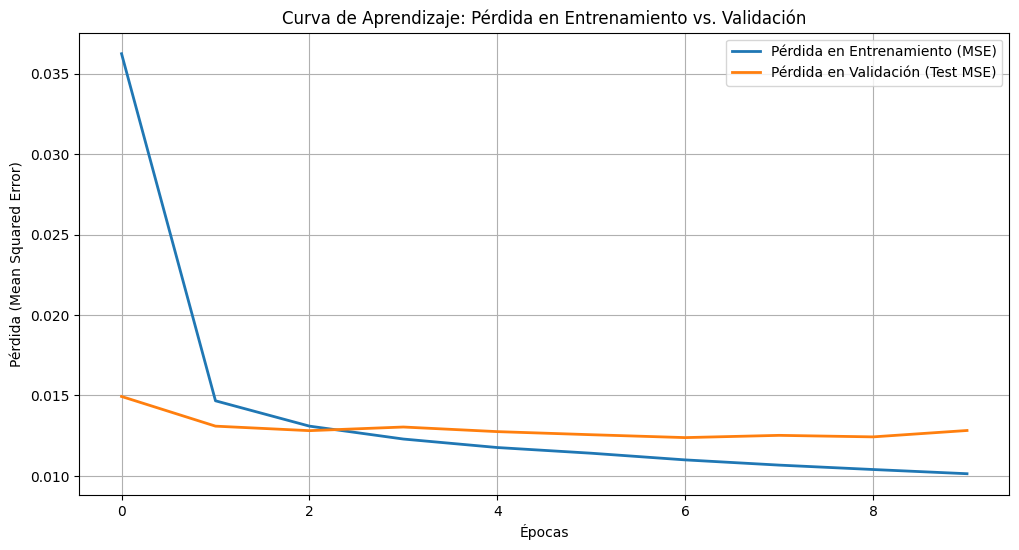

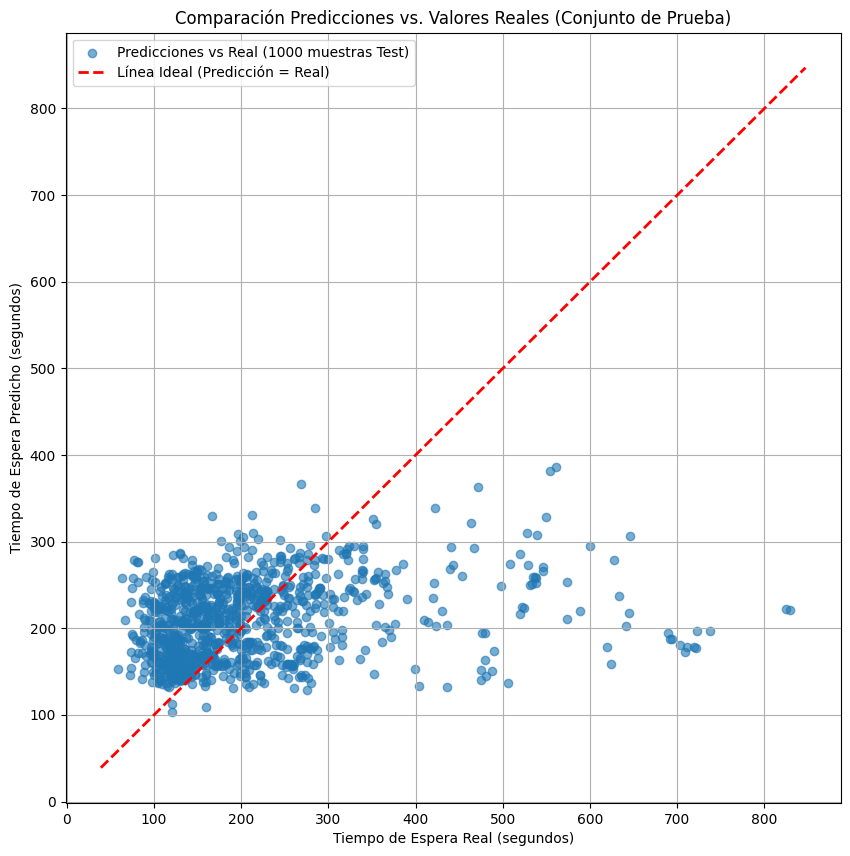

In [33]:
# --- 10. Visualización de Resultados ---

print("\nGenerando gráficos de evaluación...")

# Gráfico de Pérdida (Loss) durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento (MSE)', linewidth=2)
plt.plot(history.history['val_loss'], label='Pérdida en Validación (Test MSE)', linewidth=2)
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Mean Squared Error)')
plt.title('Curva de Aprendizaje: Pérdida en Entrenamiento vs. Validación')
plt.legend()
plt.grid(True)
plt.show() # Esto mostrará el gráfico en el notebook

# Gráfico de Predicciones vs. Valores Reales
# Graficamos una muestra aleatoria de puntos para evitar saturación si hay muchos datos.
plt.figure(figsize=(10, 10))
sample_size = min(1000, len(y_test_inv)) # Tomamos hasta 1000 puntos de muestra
indices = np.random.choice(len(y_test_inv), sample_size, replace=False)

plt.scatter(y_test_inv[indices], y_pred[indices], alpha=0.6, label=f'Predicciones vs Real ({sample_size} muestras Test)')
# Línea ideal y=x para referencia
min_val = min(np.min(y_test_inv), np.min(y_pred))
max_val = max(np.max(y_test_inv), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Línea Ideal (Predicción = Real)')

plt.xlabel('Tiempo de Espera Real (segundos)')
plt.ylabel('Tiempo de Espera Predicho (segundos)')
plt.title('Comparación Predicciones vs. Valores Reales (Conjunto de Prueba)')
plt.legend()
plt.grid(True)
# Ajustamos los límites para una mejor visualización si es necesario
# plt.xlim(0, max(y_test_inv.max(), y_pred.max()) * 1.1)
# plt.ylim(0, max(y_test_inv.max(), y_pred.max()) * 1.1)
plt.show() # Esto mostrará el segundo gráfico

In [34]:
# --- 11. Detener Spark Session ---
# Es una buena práctica detener la sesión de Spark cuando hemos terminado.
print("\nDeteniendo Spark Session...")
spark.stop()
print("Spark Session detenida. Proceso completado.")


Deteniendo Spark Session...
Spark Session detenida. Proceso completado.
